In [1]:
initial_path = 'peptide-QML'
# initial_path = '..'

In [2]:
import sys, random
sys.path.append(initial_path)

%load_ext autoreload
%autoreload 2
from my_code import helper_classes as c
from my_code import pytorch_model as m
from my_code import quantum_nodes as q

In [3]:
# name of the notebook
name_notebook = "sweep_6h_e_Xqm_oi_v4"

In [4]:
# sweep = c.Sweep(
#     name_notebook, 
#     initial_path=initial_path,
#     description="(6aa, 6q) (generate inputs) Try to find best number of q. layers, measurement, and type of Anzatz.",
#     repetitions=list(range(1, 4)),
#     ansatz=[q.parts.Ansatz_11, q.parts.Ansatz_full_conn, q.parts.Ansatz_11_2],
#     measurement = [1, 'all'],
#     block_n_layers=[4,9,14,19,24,29],
# )

In [5]:
# sweep.save()

In [6]:
sweep = c.Sweep.load(file_name=name_notebook+"-1", day='1004', initial_path=initial_path)



 --- SWEEP POINT 1/108: (1, <class 'my_code.quantum_nodes.parts.Ansatz_11'>, 1, 4) ---
 --- parameters sweeping: ['repetitions', 'ansatz', 'measurement', 'block_n_layers'] 

Epoch [0/20], Loss epoch: 152.5549, Loss validation: 153.9552
	 Validation string, 	 i: 58; 	 prediction: -12.0655, 	 target: -12.8600, 	 loss: 0.6312
	 Validation string, 	 i: 6; 	 prediction: -9.2042, 	 target: -9.3000, 	 loss: 0.0092
	 Validation string, 	 i: 29; 	 prediction: -10.1340, 	 target: -13.7700, 	 loss: 13.2207
Epoch [1/20], Loss epoch: 52.4725, Loss validation: 23.3976, Time remaining: ~0.0h 11.0m 11s
	 Validation string, 	 i: 27; 	 prediction: -13.4099, 	 target: -9.6500, 	 loss: 14.1367
	 Validation string, 	 i: 81; 	 prediction: -7.2390, 	 target: -1.5700, 	 loss: 32.1377
	 Validation string, 	 i: 99; 	 prediction: -7.3686, 	 target: -1.4300, 	 loss: 35.2668
Epoch [2/20], Loss epoch: 28.8120, Loss validation: 19.8644, Time remaining: ~0.0h 10.0m 0s
	 Validation string, 	 i: 64; 	 prediction: -10

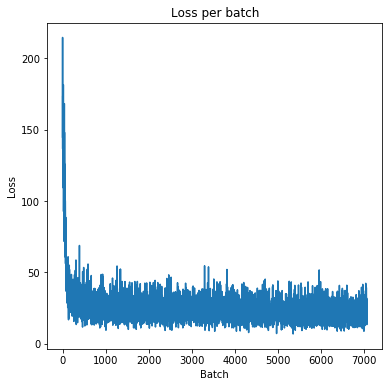

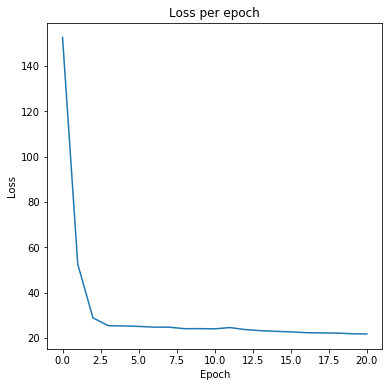

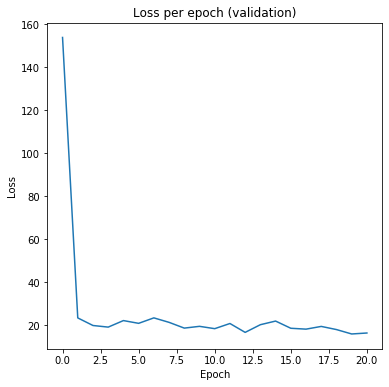

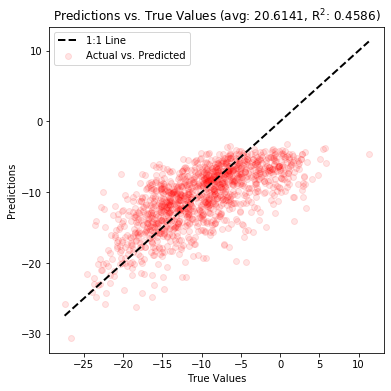

Mean loss: 20.614057679376195, std loss: 31.439121731721347, r^2: 0.4586365190066405
Best score: -32.583571139627374 						                    20/20 peptides generated. Score -12.19319693784537. 	 Time remaining: 0.11 min 			   


 --- SWEEP POINT 2/108: (1, <class 'my_code.quantum_nodes.parts.Ansatz_11'>, 1, 9) ---
 --- time reamining: 23:38:00.27 

Epoch [0/20], Loss epoch: 147.7667, Loss validation: 148.8494


In [7]:
for sweep_point in sweep.points_left:

    # print the point of the sweep
    sweep.print_sweep_status(sweep_point['idx'])

    # -- QUANTUM BLOCK -- #
    n_qubits = 6
    quantum_layer = q.circuit(
        n_qubits = n_qubits, 
        device = "default.qubit.torch",
        device_options = {'shots': None},
        embedding = q.parts.AngleEmbedding,
        # embedding_ansatz = sweep_point['ansatz'],
        block_ansatz = sweep_point['ansatz'],
        final_ansatz = sweep_point['ansatz'], 
        measurement = q.parts.Measurement('Z', sweep_point['measurement']),
        # embedding_n_layers = sweep_point['embedding_n_layers'],
        # different_inputs_per_layer = False,
        block_n_layers = sweep_point['block_n_layers'],
        # wrapper_qlayer = pw.QLayerEmpty,
    )

    # -- MODEL -- #   

    class Tan(m.nn.Module):
        def __init__(self):
            super(Tan, self).__init__()

        def forward(self, x):
            return m.torch.tan(x * m.np.pi / 2)    
                
    class Model(m.Model):
        def __init__(self):
            super(Model, self).__init__()
            self.fc1 = m.nn.Embedding(num_embeddings=19, embedding_dim=1)
            self.fc2 = m.Reshape()
            self.fc3 = quantum_layer()   
            qubits_measured = n_qubits if sweep_point['measurement']=='all' else 1
            self.fc4 = m.nn.Linear(qubits_measured, qubits_measured)         
            self.fc5 = Tan()
            self.fc6 = m.nn.Linear(qubits_measured, 1)

        def forward(self, x):
            for i in [1,2,3,4,5,6]:
                x = getattr(self, 'fc{}'.format(i))(x)
            return x

    model = Model()

    # set seed
    seed_random = random.randint(0, 1000000)
    m.torch.manual_seed(seed_random)

    # set quantum layer
    model.set_quantum_layer(quantum_layer)

    # set the name and path of the model
    model.set_name_and_path(name_notebook, initial_path)

    #set sweep point
    model.set_sweep_point(
        sweep_uuid = sweep.uuid,
        sweep_point = sweep_point,
        day=sweep.day
    )

    # -- TRAIN -- #
    model.optimize_params(
        #save info
        save_model_info = True,
        description = 'sweep with 6 aa and 6 q -> Try to find best number of q. layers, measurement, and type of Anzatz.',    
        #data
        data=c.Data.load(initial_path=initial_path, file_name='PE_SCORES_6_Numbers'),
        # train options
        optimizer = m.optim.Adam,
        optimizer_options = {'lr': 0.01},
        num_epochs = 20,                
        batch_size = 32,
        # early stopping options
        stop_training_options = {
            'lookback_epochs': 5, 
            'threshold_slope': 0.001,
            'threshold_std_dev': 0.2
        },
        # metadata
        metadata = {
            'seed_random': seed_random,
            'Tan_layer': 'tan(x * pi/2)',
        }
    )

    # load best model
    model.load_state_dict_from_results(state_dict_name="parameters_epoch", rule="best")

    # -- VALIDATION and PLOTS -- #
    model.plot_losses(fig_size=(6,6))
    model.validate(
        pct=1,
        add_to_results=True,
        plot=True,
        print_items=False
    )

    # -- SAVE RESULTS -- #
    model.save_results()

    # -- GENERATE PEPTIDES and SAVE THEM -- #    
    oi_time = m.t.time()
    n_peptides = 20
    for i in range(n_peptides):
        model.get_input_with_low_score(
            layers_to_use = ['fc3', 'fc4', 'fc5', 'fc6'],
            n_iter = 1000,
            optimizer = m.torch.optim.Adam,
            optimizer_options = {'lr': 0.1},
            stop_criterion = 1e-3,
            initialization_seed = i,
        )
        print("{}/{} peptides generated. Score {}. \t Time remaining: {:.2f} min \t\t\t ".format(
            i+1, n_peptides, model.optimized_inputs[-1][1], (n_peptides-i)*(m.t.time() - oi_time)/(i+1)/60
        ), end='\r')
    oi_time = m.t.time() - oi_time
    model.save_input_optimization_results()
    best_oi, best_oi_score = model.best_optimized_input
    print("Best score: {} \t\t\t\t\t\t  ".format(best_oi_score))

    # -- ADD DATA GENERATED TO SWEEP -- #
    sweep.add_data(
        idx=sweep_point['idx'],
        model_uuid=model.uuid,
        best_loss_train=model.results.loss_epoch.best,
        best_loss_test=model.results.loss_validation_epoch.best,
        loss_validation=model.mean_loss_validation,
        loss_validation_r_squared=model.results.validation['r_squared'],
        n_parameters=model.n_parameters,
        time_train=model.results.time_epoch.last,
        best_oi=best_oi,
        best_oi_score=best_oi_score,
        oi_time=oi_time,
    )
    sweep.save(csv=False) #TODO: save csv=False automatically when sweep is already saved ion csv

    